# Cargamos Datos

In [33]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [34]:
path = '/shared/pytorch-CycleGAN-and-pix2pix/results_TFG/Colorization_Clinic_CanRuti/test_latest/images'

In [35]:
# Recogida de archivos dentro de las carpetas del Dataset
variant = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE') 
atypical = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE')
blast = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/BLAST')

In [36]:
# elaboración de una función de regular expression
def catcher(x): return re.findall('([a-zA-Z]+_+[\d]+)', x)[0]


In [37]:
# Transformación de los nombres de archivo para seleccionar los archivos de un dataset fake
variant_png = [catcher(i)+'_fake_B_rgb.png' for i in variant]
atypical_png = [catcher(i)+'_fake_B_rgb.png' for i in atypical]
blast_png = [catcher(i)+'_fake_B_rgb.png' for i in blast]

In [38]:
# Migración de las imagenes a las carpetas de destino
for i in variant_png:
    copyfile(os.path.join(path,i), os.path.join("/shared/CanRuti_Fake_Colorization/VARIANT_LYMPHOCYTE", i))
    
for i in blast_png:
    copyfile(os.path.join(path,i), os.path.join("/shared/CanRuti_Fake_Colorization/BLAST", i))
    
for i in atypical_png:
    copyfile(os.path.join(path,i), os.path.join("/shared/CanRuti_Fake_Colorization/ATYPICAL_LYMPHOCYTE", i))
    

In [39]:
# Se seleccionan las imágenes

folder_1 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Colorization/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Colorization/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Colorization/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
N,47,57,80


In [40]:
folder_classes = "/shared/Datasets_Classification/CanRuti_Fake_Colorization"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)


#### Creación del DataBunch de las imágenes de Can Ruti Fake

Aunque haya una separación del 50 por ciento en cada set, solo se utilizará un conjunto de validación para el test, el de training se ignorará

In [41]:
df_train = pd.read_csv('/shared/can_ruti/train.csv')
df_train['x'] = df_train['x'].apply(lambda x: x.replace('.jpg', '_fake_B_rgb.png'))
df_train['z'] = False
df_train.head()

,x,y,z
0,BLAST/BL_10600573_fake_B_rgb.png,BLAST,False
1,BLAST/BL_13076127_fake_B_rgb.png,BLAST,False
2,BLAST/BL_12630836_fake_B_rgb.png,BLAST,False
3,BLAST/BL_10600634_fake_B_rgb.png,BLAST,False
4,BLAST/BL_12630955_fake_B_rgb.png,BLAST,False


In [42]:
df_valid = pd.read_csv('/shared/can_ruti/validation.csv')
df_valid['x'] = df_valid['x'].apply(lambda x: x.replace('.jpg', '_fake_B_rgb.png'))
df_valid['z'] = True
df_valid.head()

,x,y,z
0,ATYPICAL_LYMPHOCYTE/LY_13166703_fake_B_rgb.png,ATYPICAL_LYMPHOCYTE,True
1,ATYPICAL_LYMPHOCYTE/LY_13103960_fake_B_rgb.png,ATYPICAL_LYMPHOCYTE,True
2,BLAST/BL_10600656_fake_B_rgb.png,BLAST,True
3,VARIANT_LYMPHOCYTE/LY_13130834_fake_B_rgb.png,VARIANT_LYMPHOCYTE,True
4,BLAST/BL_10600719_fake_B_rgb.png,BLAST,True


In [43]:
df_split = pd.concat([df_train, df_valid])
df_split = df_split.rename(columns={'x': 'name','y': 'label','z':'is_valid'})
df_split.head()

,name,label,is_valid
0,BLAST/BL_10600573_fake_B_rgb.png,BLAST,False
1,BLAST/BL_13076127_fake_B_rgb.png,BLAST,False
2,BLAST/BL_12630836_fake_B_rgb.png,BLAST,False
3,BLAST/BL_10600634_fake_B_rgb.png,BLAST,False
4,BLAST/BL_12630955_fake_B_rgb.png,BLAST,False


In [44]:
folder_classes

'/shared/Datasets_Classification/CanRuti_Fake_Colorization'

In [45]:
data = (ImageList.from_df(df_split, folder_classes) # importamos datos mediante df
        .split_from_df()         # separamos en train/validation mediante df
        .label_from_folder()            # Damos las etiquetas por el nombre de la carpeta
        .transform(tfms, size=224)       # Data augmentation incluida
        .databunch(num_workers=0)
        .normalize(imagenet_stats))   

In [46]:
data.batch_size = 20

#### Descripción del Conjunto de datos Can Ruti Fake

In [47]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

,N
Number of classes,3
train_size,92
valid_size,92


#### Conteo de clases del conjunto de training de datos Can Ruti Fake

train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

#### Conteo de clases del conjunto de validación de datos Can Ruti Fake

valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

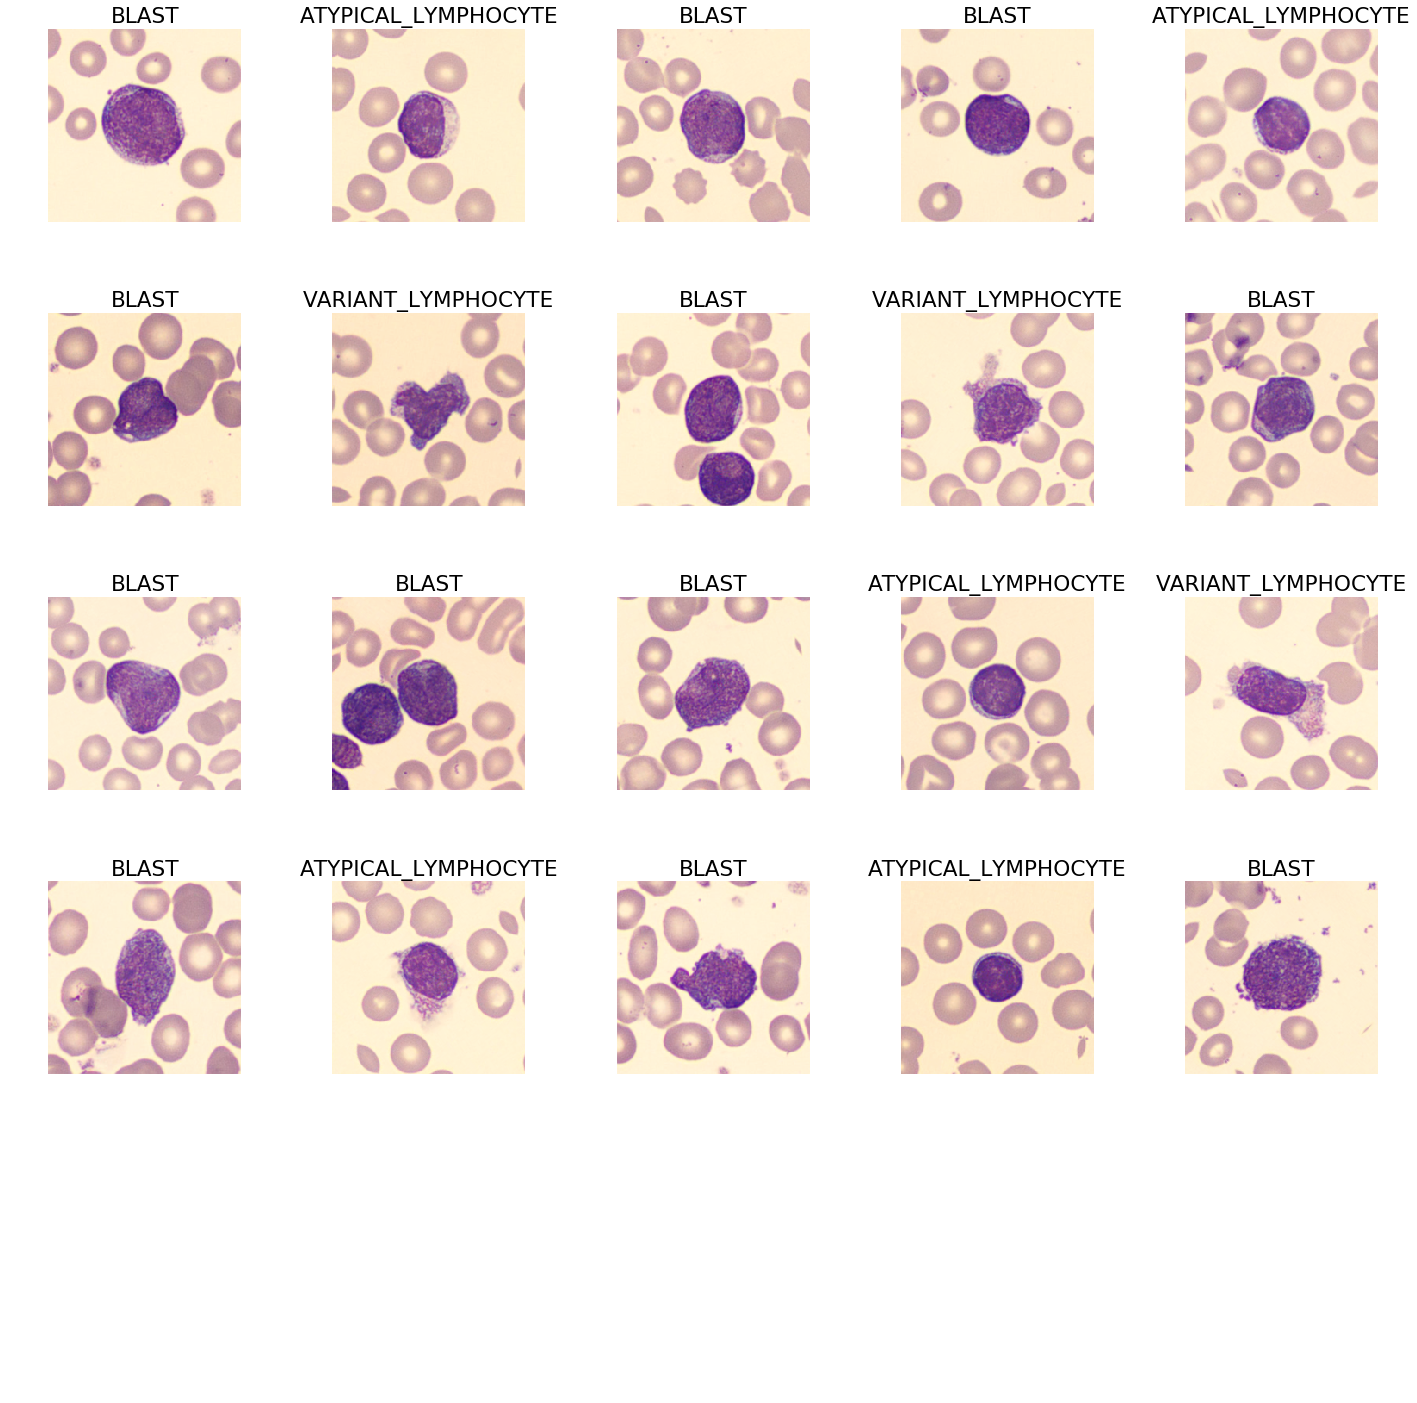

In [48]:
data.show_batch()


# Test Canruti Resnet 34 (Santi) Preentrenada en Clinic NoSind

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [49]:
data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [50]:
folder_model = "/shared/modelos"
learn = None
learn = load_learner(folder_model, 'export_Resnet34_3types_BAL_resampling_NoLGL_NoSIND.pkl')
learn.data.classes = data.classes

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [51]:
learn.data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [52]:
learn.data = data

In [53]:
learn.data.batch_size = 20

In [54]:
gc.collect()

0

In [55]:

results = learn.validate(data.valid_dl)
plt.rcParams.update({'font.size': 18})
valid_CanRuti = dict(zip(['valid_loss', 'accuracy'],
                         [results[0], results[1].item()]))

pd.DataFrame(valid_CanRuti, index = ['metrics'])

,valid_loss,accuracy
metrics,2.87405,0.51087


In [56]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({#'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,precision,recall
metrics,0.51087,0.51087


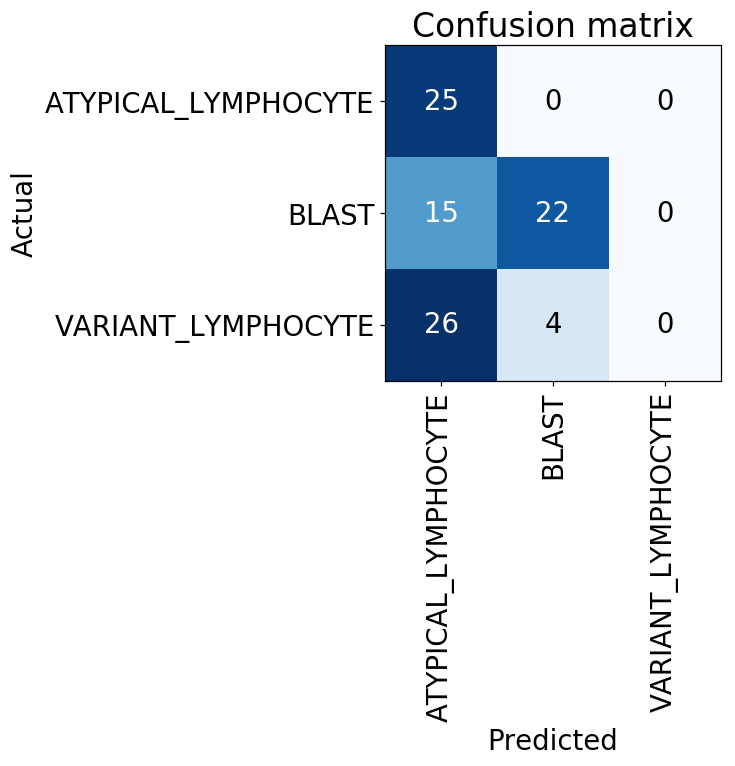

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

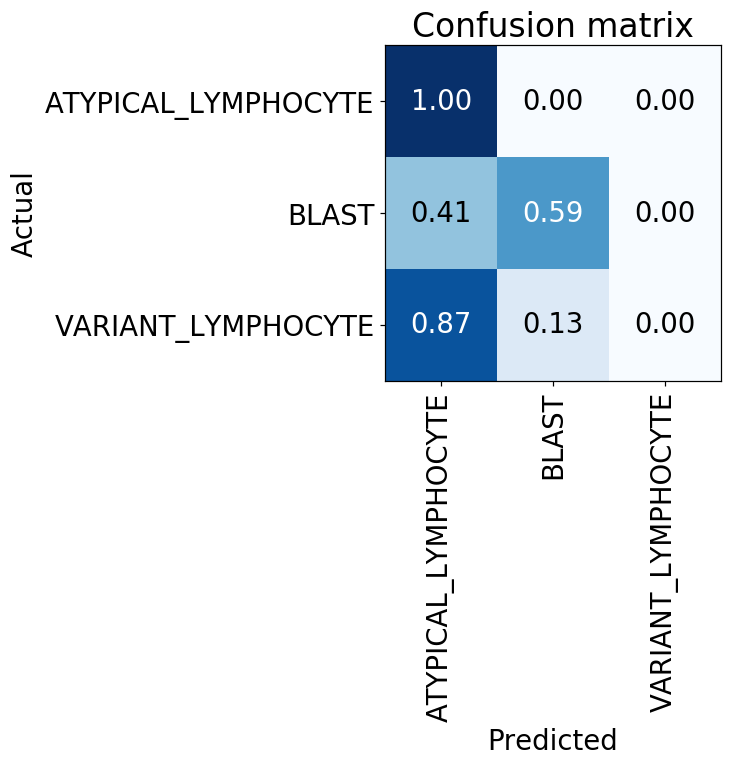

In [36]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [59]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.684217,1.833889,0.663043,00:01
1,0.436766,1.529953,0.630435,00:01
2,0.328469,0.656215,0.815217,00:01


In [60]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.121422,0.485268,0.869565,00:01
1,0.115459,0.298983,0.934783,00:01
2,0.223907,0.185959,0.945652,00:01


In [61]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.139572,0.102271,0.956522,00:01
1,0.240925,0.256105,0.902174,00:01
2,0.184417,0.203813,0.913043,00:01


In [62]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.176311,0.402052,0.913043,00:01
1,0.164574,0.633199,0.847826,00:01
2,0.173576,0.244909,0.934783,00:01


In [63]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.122574,0.147622,0.945652,00:01
1,0.176888,0.252706,0.902174,00:01
2,0.139340,0.248672,0.913043,00:01


In [64]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.173412,0.196114,0.934783,00:01
1,0.114997,0.107629,0.945652,00:01
2,0.081244,0.071271,0.967391,00:01


In [67]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 
y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))
pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true)}, index = ['metrics'])

,multiclass_roc_auc_score
metrics,0.975543


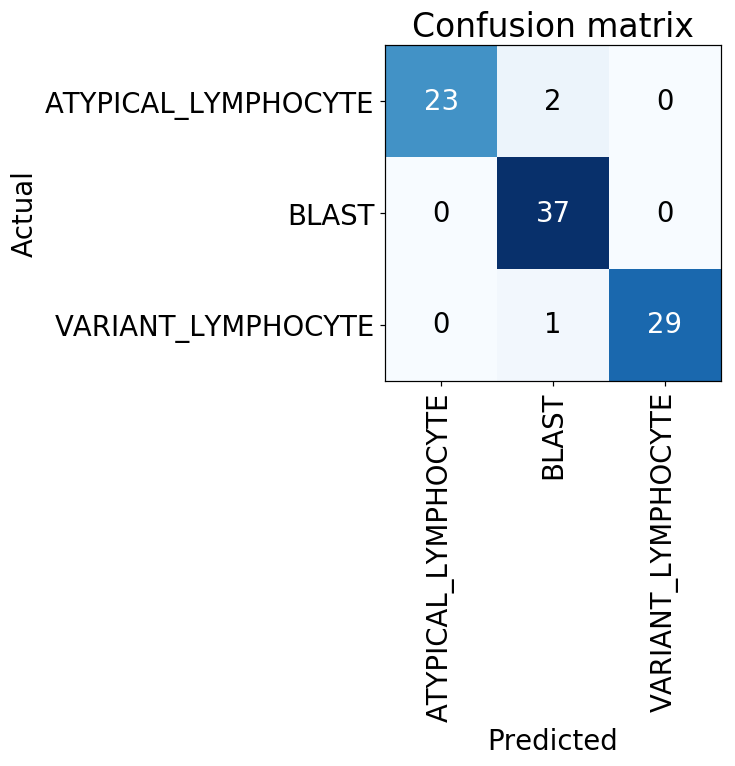

In [65]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, norm_dec=2 )

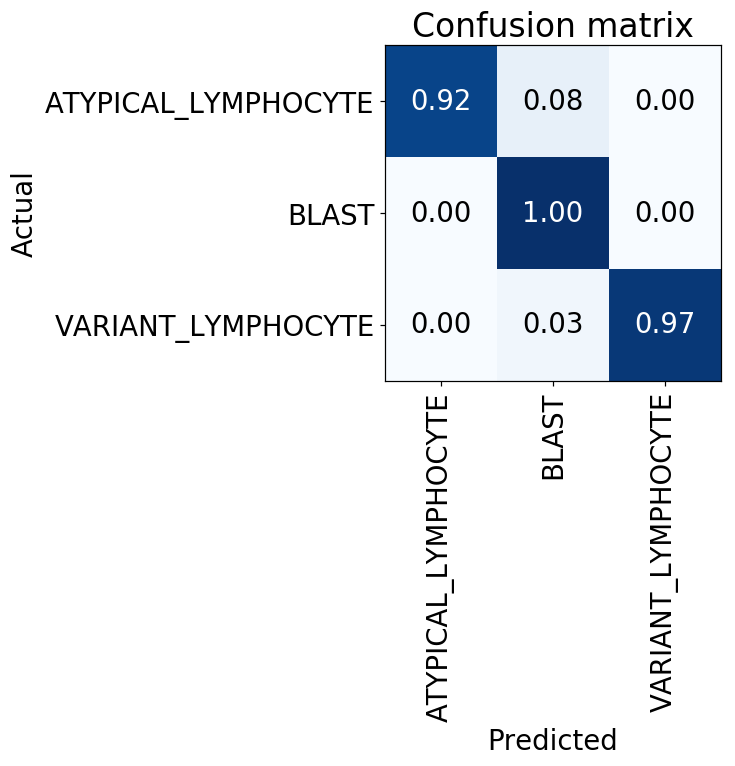

In [66]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [ ]:
interp.plot_top_losses(9, largest=True, figsize=(40,40), heatmap=True)
